In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# /kaggle/input/garbage-classification/one-indexed-files-notrash_val.txt
# /kaggle/input/garbage-classification/one-indexed-files-notrash_train.txt
# /kaggle/input/garbage-classification/zero-indexed-files.txt
# /kaggle/input/garbage-classification/one-indexed-files.txt
# /kaggle/input/garbage-classification/one-indexed-files-notrash_test.txt

/kaggle/input/garbage-classification/one-indexed-files-notrash_val.txt
/kaggle/input/garbage-classification/one-indexed-files-notrash_train.txt
/kaggle/input/garbage-classification/zero-indexed-files.txt
/kaggle/input/garbage-classification/one-indexed-files.txt
/kaggle/input/garbage-classification/one-indexed-files-notrash_test.txt
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal375.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal341.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal374.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal383.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal215.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal113.jpg
/kaggle/input/garbage-classification/Garbage classifi

Plan: 
1. Whitch transformations and how
2. Basic model
3. ResNet50
4. Experminetation
   - Do we have to deal with imbalance and how
   - implement GANs

# Garbage Classification using PyTorch

The goal of this notebook is to corectly cassify garbages. 
Baes on dataset description we know that there are 6 classes. 

- cardboard (393)
- glass (491)
- metal (400)
- paper(584)
- plastic (472)
- trash (127)

## My wrok will consist of 2 approches 
Firsty i will ceate my own, custom CNN. 
Secondly i will use ResNet50 network to levrage its training into my problem.

As a summary i will compare performace of both models.


### Choosing the right metrics 
Because this is fairly unbalanced dataset `accuracy` may not be the best choice.
We will focus more on `precison` and `recall` as well as on `F1 score`. 


In [3]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Tools 


from PIL import Image
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score,MulticlassPrecision,MulticlassRecall
import torch.optim as optim 
from torchsummary import summary

from sklearn.model_selection import StratifiedShuffleSplit

# Resnet
from torchvision.models import resnet50, ResNet50_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# Metrics, we are using macro becuase dataset is unbalanced
accuracy = MulticlassAccuracy(num_classes=6, average="macro").to(device)
f1 = MulticlassF1Score(num_classes=6, average="macro").to(device)
precision = MulticlassPrecision(num_classes=6, average="macro").to(device)
recall = MulticlassRecall(num_classes=6, average="macro").to(device)

# Validation metrics
val_accuracy = MulticlassAccuracy(num_classes=6, average="macro").to(device)
val_f1 = MulticlassF1Score(num_classes=6, average="macro").to(device)
val_precision = MulticlassPrecision(num_classes=6, average="macro").to(device)
val_recall = MulticlassRecall(num_classes=6, average="macro").to(device)

# Getting data ready 
Images in the dataset are accessed by their paths (locations). So to be able to work with them we need to list all the files in folders

In [31]:
base_directory = "/kaggle/input/garbage-classification/Garbage classification/Garbage classification/"

img_paths = []
labels = []

for class_name in os.listdir(base_directory):
    class_path = os.path.join(base_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img_paths.append(image_path)
        labels.append(class_name)

In [32]:
print(f"Total number of images {len(img_paths)}")
print(f"Total number of labels {len(labels)}")
print(f"Example path : {img_paths[0]}")
print(f"Label of above image: {labels[0]}")

Total number of images 2527
Total number of labels 2527
Example path : /kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal375.jpg
Label of above image: metal


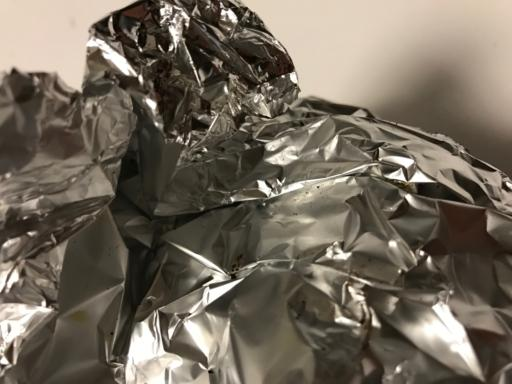

In [33]:
image_example = Image.open(img_paths[2])
image_example

### The best way to store our dataset is in Pandas DataFrame or use PyTorch ImageFolder
Our data are organized in folders in the way that using ImageFoldermethod mayby ideal to the task 

In [34]:
data_to_better_understaning = pd.DataFrame({  # Experimenting with DataFrame format
    "path": img_paths,
    "label": labels
})

In [35]:
# data = list(zip(img_paths,labels))  Experimenting with list of tuples 
# data[:2]

## Transformation 

In [36]:
# Transformation pipeline Train and Validation
train_transform = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True), # prepare for ResNet50 
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224,224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Loading dataset into ImageFolder

In [37]:
dataset = ImageFolder(root=base_directory)

In [38]:
dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /kaggle/input/garbage-classification/Garbage classification/Garbage classification/

In [39]:
split_data = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

data_indexes = np.arange(len(labels)) # [0,1,2,3...2526] allows us to operate on indexes of data and split data by indexes 

for train_indexes, val_indexes in split_data.split(data_indexes,labels):
    print(train_indexes)
    print(val_indexes)
    

[1510  574  748 ... 1024  761  221]
[2163   74  112 1854  503  526  957 1449  794  364 2275 1990 1377 1830
 1970 1062  594 2301 1047   93 2042 1885  749 1059  687 1915  419 2054
  632  663  224  766  242 1468 1748  688 1532  833  856 1393 1376  222
 2079 2001 1160 1206 1111  228 1245  100  996 2414  750 2209  638  758
  246 1643  276  992 1008 1185 1843 2200  803 1311 1584 2189 2072 1634
  917  538 1023 1733 1333  900 1386 2014  937 1831  655 1957 1082 1301
 1400 1521 2219  314 1203 1452 1334  728  848 2056 2411 2028  979 2329
 2242  563  332  160  392 1249 1387 1905 1225  133 1856   61  457   33
 2491  589 1901 1986 1058 1803 2468  878 2131 1498 1808 1918 2331 2516
  330  836 1685 1018 1696   46 2052  553  410 1877 2369 1481 1127 2046
  666  536 1508  720  991 2425  667 2349 1620 2434 2466 1535  561 1577
 1399  179 1360    9  292  110  432  408 1694 2038  684 1776 1793 1832
  971  745 1273  485 2251  149 2389 2152   30 2005  274  613 1198  698
 2308  505 2273  782  533 2128  779 2110 

In [62]:
print(len(train_indexes))

2021


In [63]:
print(len(val_indexes))

506


In [64]:
train_indexes

array([1510,  574,  748, ..., 1024,  761,  221])

In [65]:
val_indexes[:10]

array([2163,   74,  112, 1854,  503,  526,  957, 1449,  794,  364])

In [82]:
labels_val = []
labels_test = []
for i in train_indexes:
    labels_test.append(data_to_better_understaning.iloc[i]["label"])

for i in val_indexes:
    labels_val.append(data_to_better_understaning.iloc[i]["label"])


labels_test = pd.Series(labels_test)
labels_val = pd.Series(labels_val)

print(labels_test.value_counts(normalize=True))
print(labels_val.value_counts(normalize=True))

# The results of data split seems to be done right, taking under consideration StratifiedShuffleSplit  

paper        0.235032
glass        0.198417
plastic      0.190500
metal        0.162296
cardboard    0.159327
trash        0.054429
Name: proportion, dtype: float64
paper        0.235178
glass        0.197628
plastic      0.191700
metal        0.162055
cardboard    0.160079
trash        0.053360
Name: proportion, dtype: float64


In [21]:
data_to_better_understaning.iloc[train_indexes[0]]
# Thats how train-indexes works based on easier to imagine example of dataset in form of DataFrame
# train_indexes are jsut indexes of data we have in dataset

path     /kaggle/input/garbage-classification/Garbage c...
label                                                trash
Name: 1510, dtype: object

### Create a train and validation data set

In [84]:
train_data = Subset(dataset, train_indexes)
val_data = Subset(dataset, val_indexes)

In [85]:
train_data[0] # As we can see it is in format of PIL, se we need to add to Tranfomration v2.ToImage(),  ==  Convert to tensor, only needed if you had a PIL image

(<PIL.Image.Image image mode=RGB size=512x384>, 3)

### Apply data transformations


In [86]:
train_data.dataset.transform = train_transform
val_data.dataset.transform = val_transform

In [87]:
type(train_data)

torch.utils.data.dataset.Subset

In [88]:
train_data[0][0] # Image

Image([[[ 1.9407,  1.9578,  1.9749,  ...,  1.3070,  1.2899,  1.2728],
        [ 1.9407,  1.9578,  1.9749,  ...,  1.3070,  1.2899,  1.2899],
        [ 1.9407,  1.9578,  1.9749,  ...,  1.3242,  1.3070,  1.2899],
        ...,
        [-0.5424,  0.2796,  1.1358,  ...,  1.3070,  1.2899,  1.2728],
        [-1.4500, -1.4672, -1.1760,  ...,  1.3070,  1.2899,  1.2728],
        [-1.5185, -1.5185, -1.4500,  ...,  1.3070,  1.2899,  1.2728]],

       [[ 1.9559,  1.9734,  1.9909,  ...,  1.2381,  1.2206,  1.2031],
        [ 1.9559,  1.9734,  1.9909,  ...,  1.2381,  1.2206,  1.2206],
        [ 1.9559,  1.9734,  1.9909,  ...,  1.2556,  1.2381,  1.2206],
        ...,
        [-0.5126,  0.3277,  1.2031,  ...,  1.3957,  1.3782,  1.3606],
        [-1.4405, -1.4580, -1.1604,  ...,  1.3957,  1.3782,  1.3606],
        [-1.5105, -1.5105, -1.4405,  ...,  1.3957,  1.3782,  1.3606]],

       [[ 2.0125,  2.0300,  2.0474,  ...,  1.1585,  1.1411,  1.1237],
        [ 2.0125,  2.0300,  2.0474,  ...,  1.1585,  1.1411, 

In [89]:
train_data[0][1] # Label
 

3

### DataLoaders 
We need to crate batches of data (no need to separate X and y by hand) 

In [116]:
def create_data_loader(data, batches, shuffle=True): 
    """Function will create data loaders out of ImageFolder classes"""
    loader = DataLoader(data,batches,shuffle)
    return loader

In [25]:
train_data_loader = create_data_loader(train_data,32)
val_data_loader = create_data_loader(data=val_data,batches=32,shuffle=False)

### Function to train and validate model 


In [122]:
def train_with_validation(model,train_loader,loss_function, optimizer,epochs,val_loder= None):
    
    model.to(device)
    torch.manual_seed(42)
    
    train_loss_arr = []
    val_loss_arr = []
    epochs_arr = []
    for epoch in range(epochs):

        model.train()
        
        accuracy.reset()
        f1.reset()
        precision.reset() 
        recall.reset()
        train_loss_batch = 0
        
        val_loss_batch = 0
        val_accuracy.reset()
        val_f1.reset()
        val_precision.reset()
        val_recall.reset()

        epochs_arr.append(epoch)
        for X, y in train_loader:
            X,y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_function(preds,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_batch += loss.item()
            accuracy.update(preds,y)
            f1.update(preds,y)
            precision.update(preds,y)
            recall.update(preds,y)
            
        train_loss = train_loss_batch/len(train_loader)
        train_loss_arr.append(train_loss)
        train_acc = accuracy.compute().item()
        train_precision = precision.compute().item()
        train_recall = recall.compute().item()
        train_f1 = f1.compute().item()
       
        results_dict = {
        "Train Accuracy": train_acc,
        "Train Precision": train_precision,
        "Train Recall":train_recall,
        "Train F1": train_f1,
        }
        
        if val_loder is not None:
            # validation
            with torch.inference_mode():
                model.eval()
                for X_val, y_val in val_loder:
                    X_val,y_val= X_val.to(device), y_val.to(device)
                    predictions = model(X_val)
                    loss_val = loss_function(predictions, y_val)
                    val_loss_batch += loss_val.item()

                    val_accuracy.update(predictions, y_val)
                    val_f1.update(predictions, y_val)
                    val_precision.update(predictions, y_val)
                    val_recall.update(predictions, y_val)
                
                val_loss_ = val_loss_batch/len(val_loder)
                val_loss_arr.append(val_loss_)
                val_acc_ = val_accuracy.compute().item()
                val_precision_ = val_precision.compute().item()
                val_recall_ = val_recall.compute().item()
                val_f1_ = val_f1.compute().item()

                results_dict_val = {
                    "Test Accuracy": val_acc_,
                    "Test Precision": val_precision_,
                    "Test Recall": val_recall_,
                    "Test F1": val_f1_ 
                    }

                results_dict.update(results_dict_val)
        
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch + 1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
            if val_loder is not None:
                print(f"Val Loss: {val_loss_:.4f}, Val Accuracy: {val_acc_:.4f}, Val F1: {val_f1_:.4f}, Val Precision: {val_precision_:.4f}, Val Recall: {val_recall_:.4f}")
  
    plot_loss(train_loss_arr,val_loss_arr,epochs_arr)
    
    return results_dict
                        
                    



In [27]:
def plot_loss(train_loss, val_loss, epochs):
    """Function will use Traing loss and Validation/Test Loss in form of arryas to prin loss per epoch"""
    if val_loss :
        plt.plot(epochs, val_loss, label ="Validation/Test Loss")
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Base Model 

In [139]:
class base_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(),
            
            nn.Conv2d(64,128,3,1,1), 
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2), 
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(128,256,3,1,1), 
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2), 
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Flatten(),
            nn.Linear(256*28*28,512), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,6)
        )

    def forward(self,x):
        return self.layers(x)





In [ ]:
base_model = base_model()
base_loss = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(base_model.parameters(), lr=0.001)

In [29]:
summary(base_model.to(device),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         MaxPool2d-3         [-1, 64, 112, 112]               0
              ReLU-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
         MaxPool2d-7          [-1, 128, 56, 56]               0
              ReLU-8          [-1, 128, 56, 56]               0
           Dropout-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 256, 56, 56]         295,168
      BatchNorm2d-11          [-1, 256, 56, 56]             512
        MaxPool2d-12          [-1, 256, 28, 28]               0
             ReLU-13          [-1, 256, 28, 28]               0
          Dropout-14          [-1, 256,

In [30]:
base_model_results = train_with_validation(base_model,train_data_loader,base_loss,base_optimizer,50,val_loder=val_data_loader)



# Epoch: 1/50
# Train Loss: 1.1332, Train Accuracy: 0.5376, Train F1: 0.5522, Train Precision: 0.5993, Train Recall: 0.5376
# Val Loss: 1.1772, Val Accuracy: 0.5308, Val F1: 0.5491, Val Precision: 0.6646, Val Recall: 0.5308
# Epoch: 6/50
# Train Loss: 1.1087, Train Accuracy: 0.5098, Train F1: 0.5241, Train Precision: 0.6453, Train Recall: 0.5098
# Val Loss: 1.0931, Val Accuracy: 0.5494, Val F1: 0.5638, Val Precision: 0.7032, Val Recall: 0.5494
# Epoch: 11/50
# Train Loss: 1.0933, Train Accuracy: 0.5355, Train F1: 0.5589, Train Precision: 0.6774, Train Recall: 0.5355
# Val Loss: 1.1242, Val Accuracy: 0.5871, Val F1: 0.6047, Val Precision: 0.6457, Val Recall: 0.5871
# Epoch: 16/50
# Train Loss: 1.0123, Train Accuracy: 0.5387, Train F1: 0.5555, Train Precision: 0.6836, Train Recall: 0.5387
# Val Loss: 1.0795, Val Accuracy: 0.5701, Val F1: 0.5961, Val Precision: 0.7032, Val Recall: 0.5701
# Epoch: 21/50
# Train Loss: 1.0590, Train Accuracy: 0.5269, Train F1: 0.5565, Train Precision: 0.7222, Train Recall: 0.5269
# Val Loss: 1.2385, Val Accuracy: 0.5353, Val F1: 0.5375, Val Precision: 0.6910, Val Recall: 0.5353
# Epoch: 26/50
# Train Loss: 1.0915, Train Accuracy: 0.4913, Train F1: 0.4972, Train Precision: 0.6153, Train Recall: 0.4913
# Val Loss: 1.1107, Val Accuracy: 0.5249, Val F1: 0.5165, Val Precision: 0.5636, Val Recall: 0.5249
# Epoch: 31/50
# Train Loss: 1.1128, Train Accuracy: 0.4648, Train F1: 0.4803, Train Precision: 0.6020, Train Recall: 0.4648
# Val Loss: 1.0936, Val Accuracy: 0.5319, Val F1: 0.5336, Val Precision: 0.5882, Val Recall: 0.5319
# Epoch: 36/50
# Train Loss: 0.9510, Train Accuracy: 0.5301, Train F1: 0.5374, Train Precision: 0.6096, Train Recall: 0.5301
# Val Loss: 1.1034, Val Accuracy: 0.5420, Val F1: 0.5404, Val Precision: 0.5713, Val Recall: 0.5420
# Epoch: 41/50
# Train Loss: 1.0315, Train Accuracy: 0.5224, Train F1: 0.5289, Train Precision: 0.6053, Train Recall: 0.5224
# Val Loss: 1.1401, Val Accuracy: 0.5250, Val F1: 0.5212, Val Precision: 0.5695, Val Recall: 0.5250
# Epoch: 46/50
# Train Loss: 0.9027, Train Accuracy: 0.5782, Train F1: 0.5710, Train Precision: 0.6091, Train Recall: 0.5782
# Val Loss: 1.2296, Val Accuracy: 0.5579, Val F1: 0.5464, Val Precision: 0.5539, Val Recall: 0.5579
# Epoch: 50/50
# Train Loss: 0.9648, Train Accuracy: 0.5336, Train F1: 0.5312, Train Precision: 0.5914, Train Recall: 0.5336
# Val Loss: 1.1571, Val Accuracy: 0.5660, Val F1: 0.5500, Val Precision: 0.5422, Val Recall: 0.5660


In [17]:

base_model_results_df = pd.DataFrame({
    'Train Accuracy': 0.533610999584198,
    'Train Precision': 0.5913708806037903,
    'Train Recall': 0.533610999584198,
    'Train F1': 0.5312424898147583,
    'Test Accuracy': 0.5660040378570557,
    'Test Precision': 0.5422157645225525,
    'Test Recall': 0.5660040378570557,
    'Test F1': 0.5500200986862183
}, index=["Base Model"]).T



In [18]:
base_model_results_df

,Base Model
Train Accuracy,0.533611
Train Precision,0.591371
Train Recall,0.533611
Train F1,0.531242
Test Accuracy,0.566004
Test Precision,0.542216
Test Recall,0.566004
Test F1,0.550020


# ResNET as Feature Extractor

In [60]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


In [34]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
# Freeze the layers of the ResNet50 model
for param in resnet.parameters():
    param.requires_grad = False

In [36]:
num_classes = 6  

# Replace the fully connected layer
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),  # Add an intermediate layer (optional)
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, num_classes)  # Output layer for your classes
)

In [37]:
criterion_res = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(resnet.fc.parameters(), lr=0.001)

In [38]:
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(f"{name}: requires_grad = {param.requires_grad}")


fc.0.weight: requires_grad = True
fc.0.bias: requires_grad = True
fc.3.weight: requires_grad = True
fc.3.bias: requires_grad = True


Epoch: 1/50
Train Loss: 1.0556, Train Accuracy: 0.5348, Train F1: 0.5349, Train Precision: 0.5612, Train Recall: 0.5348
Val Loss: 0.6715, Val Accuracy: 0.7139, Val F1: 0.7332, Val Precision: 0.8271, Val Recall: 0.7139
Epoch: 6/50
Train Loss: 0.4923, Train Accuracy: 0.7888, Train F1: 0.7977, Train Precision: 0.8109, Train Recall: 0.7888
Val Loss: 0.4568, Val Accuracy: 0.8234, Val F1: 0.8177, Val Precision: 0.8195, Val Recall: 0.8234
Epoch: 11/50
Train Loss: 0.4090, Train Accuracy: 0.8353, Train F1: 0.8372, Train Precision: 0.8394, Train Recall: 0.8353
Val Loss: 0.3946, Val Accuracy: 0.8158, Val F1: 0.8280, Val Precision: 0.8521, Val Recall: 0.8158
Epoch: 16/50
Train Loss: 0.3464, Train Accuracy: 0.8642, Train F1: 0.8708, Train Precision: 0.8792, Train Recall: 0.8642
Val Loss: 0.3966, Val Accuracy: 0.8233, Val F1: 0.8198, Val Precision: 0.8255, Val Recall: 0.8233
Epoch: 21/50
Train Loss: 0.3017, Train Accuracy: 0.8812, Train F1: 0.8801, Train Precision: 0.8794, Train Recall: 0.8812
Val L

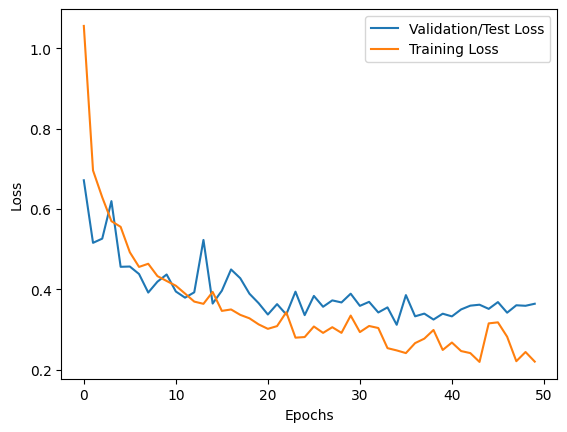

In [39]:
resnet_model_results = train_with_validation(resnet,train_data_loader,criterion_res,optimizer_res,50,val_loder=val_data_loader)


In [ ]:
resnet_model_results

What is worth to point out is that our model stops getting better some after 40th epoch. 

In [19]:
resnet_model_results_df = pd.DataFrame({'Train Accuracy': 0.9278258681297302,
 'Train Precision': 0.9280562400817871,
 'Train Recall': 0.9278258681297302,
 'Train F1': 0.9278298020362854,
 'Test Accuracy': 0.8621233105659485,
 'Test Precision': 0.8600994348526001,
 'Test Recall': 0.8621233105659485,
 'Test F1': 0.8603360056877136}, index=["ResNET50"]).T

In [20]:
resnet_model_results_df

,ResNET50
Train Accuracy,0.927826
Train Precision,0.928056
Train Recall,0.927826
Train F1,0.927830
Test Accuracy,0.862123
Test Precision,0.860099
Test Recall,0.862123
Test F1,0.860336


In [57]:
resnet_model_results_df.join(base_model_results_df).style.highlight_max(axis=1, color="pink")

,ResNET50,Base Model
Train Accuracy,0.927826,0.533611
Train Precision,0.928056,0.591371
Train Recall,0.927826,0.533611
Train F1,0.927830,0.531242
Test Accuracy,0.862123,0.566004
Test Precision,0.860099,0.542216
Test Recall,0.862123,0.566004
Test F1,0.860336,0.550020


# RESULTS AND SUMMARY
As we can see ResNET model beat in all metrics my previously designed model. 
The power or transfer learing is anormous, from 57% to 86% of accuracy in Test set without much effort. 
We could play a bit with parameters tuning of our new ResNET model to see if we can squeeze a litte bit more from it like:
-  Improve Data Augmentation seteps
-  Play with learning rate of optimzer
-  Change parameters of the last Fully Connected (fc) layer, 

# Issue 
I may found an issue with my previous implementation. The problem is with `Subset` class. 
The `Subset` class does **not make a copy** of the dataset, but stores a **reference** to the orginal dataset. That's why when i try to apply some data transforamtions to train_data and then to val_data it overrides the previous one. 
1. `dataset = ImageFolder(root=base_directory)`
2. So, firsty i do:
`train_data.dataset.transform = train_transform` - This applys train_transformations to **whole** dataset
3. Secondly i  try to make a transformation to val_data:
   `val_data.dataset.transform = val_transform` - this overrides the previous transformation on whole dataset, so on whole subsets. Both `train_data` and `val_data` 

In [124]:
# Previous code

# train_data = Subset(dataset, train_indexes)
# val_data = Subset(dataset, val_indexes)
# train_data.dataset.transform = train_transform
# val_data.dataset.transform = val_transform


print(id(dataset))        # Memory address of the original dataset
print(id(train_data.dataset))  # Should be the same as dataset
print(id(val_data.dataset))  # Should also be the same as dataset


133467519434128
133467519434128
133467519434128


As we can see, memory addreses are the same - it proves that change in for example `train_data` affects `dataset` itself and also `val_data` 

## Solution

In [134]:
# Create different datasets 
train_data_img_folder = ImageFolder(root=base_directory)
val_data_img_folder = ImageFolder(root=base_directory)

# Then split datasets to gave train and test indeces 
train_data_sub = Subset(train_data_img_folder, train_indexes)
val_data_sub = Subset(val_data_img_folder, val_indexes)

# apply transformations to datasets - now the popint to different datasets, so we can make transforamtions 
train_data_sub.dataset.transform = train_transform
val_data_sub.dataset.transform = val_transform

In [135]:

print(f"train dataset id:{id(train_data_img_folder)}")        
print(f"train Subset id:{id(train_data_sub.dataset)}")

print(f"Val dataset id:{id(val_data_img_folder)}")        
print(f"Val Subset id:{id(val_data_sub.dataset)}")

train dataset id:133467254762624
train Subset id:133467254762624
Val dataset id:133467254765216
Val Subset id:133467254765216


In [136]:
train_data_loader_ok = create_data_loader(train_data_sub,32)
val_data_loader_ok = create_data_loader(data=val_data_sub,batches=32,shuffle=False)

## Training models

In [143]:

class base_model_(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(),
            
            nn.Conv2d(64,128,3,1,1), 
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2), 
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(128,256,3,1,1), 
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2), 
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Flatten(),
            nn.Linear(256*28*28,512), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,6)
        )

    def forward(self,x):
        return self.layers(x)



base_model_ok = base_model_()
base_loss_ok = nn.CrossEntropyLoss()
base_optimizer_ok = optim.Adam(base_model_ok.parameters(), lr=0.001)

In [ ]:
base_model_ok_results = train_with_validation(base_model_ok,train_data_loader_ok,base_loss_ok,base_optimizer_ok,50,val_loder=val_data_loader_ok)

# Epoch: 1/50
# Train Loss: 22.1914, Train Accuracy: 0.2633, Train F1: 0.2603, Train Precision: 0.2700, Train Recall: 0.2633
# Val Loss: 1.6404, Val Accuracy: 0.2943, Val F1: 0.2503, Val Precision: 0.3213, Val Recall: 0.2943
# Epoch: 6/50
# Train Loss: 1.6582, Train Accuracy: 0.2610, Train F1: 0.1987, Train Precision: 0.2929, Train Recall: 0.2610
# Val Loss: 3.3013, Val Accuracy: 0.2151, Val F1: 0.1115, Val Precision: 0.1876, Val Recall: 0.2151
# Epoch: 11/50
# Train Loss: 1.6174, Train Accuracy: 0.2627, Train F1: 0.1860, Train Precision: 0.2405, Train Recall: 0.2627
# Val Loss: 1.6160, Val Accuracy: 0.2517, Val F1: 0.1807, Val Precision: 0.2024, Val Recall: 0.2517
# Epoch: 16/50
# Train Loss: 1.6138, Train Accuracy: 0.2658, Train F1: 0.1903, Train Precision: 0.2804, Train Recall: 0.2658
# Val Loss: 1.5595, Val Accuracy: 0.2695, Val F1: 0.1928, Val Precision: 0.2003, Val Recall: 0.2695
# Epoch: 21/50
# Train Loss: 1.6519, Train Accuracy: 0.2255, Train F1: 0.1508, Train Precision: 0.1760, Train Recall: 0.2255
# Val Loss: 1.5646, Val Accuracy: 0.2609, Val F1: 0.1876, Val Precision: 0.2823, Val Recall: 0.2609
# Epoch: 26/50
# Train Loss: 1.6092, Train Accuracy: 0.2474, Train F1: 0.1758, Train Precision: 0.2446, Train Recall: 0.2474
# Val Loss: 1.5469, Val Accuracy: 0.2654, Val F1: 0.1908, Val Precision: 0.2032, Val Recall: 0.2654
# Epoch: 31/50
# Train Loss: 1.6426, Train Accuracy: 0.2383, Train F1: 0.1658, Train Precision: 0.1964, Train Recall: 0.2383
# Val Loss: 1.5856, Val Accuracy: 0.2366, Val F1: 0.1648, Val Precision: 0.2039, Val Recall: 0.2366

Epoch: 1/50
Train Loss: 22.1914, Train Accuracy: 0.2633, Train F1: 0.2603, Train Precision: 0.2700, Train Recall: 0.2633
Val Loss: 1.6404, Val Accuracy: 0.2943, Val F1: 0.2503, Val Precision: 0.3213, Val Recall: 0.2943
Epoch: 6/50
Train Loss: 1.6582, Train Accuracy: 0.2610, Train F1: 0.1987, Train Precision: 0.2929, Train Recall: 0.2610
Val Loss: 3.3013, Val Accuracy: 0.2151, Val F1: 0.1115, Val Precision: 0.1876, Val Recall: 0.2151
Epoch: 11/50
Train Loss: 1.6174, Train Accuracy: 0.2627, Train F1: 0.1860, Train Precision: 0.2405, Train Recall: 0.2627
Val Loss: 1.6160, Val Accuracy: 0.2517, Val F1: 0.1807, Val Precision: 0.2024, Val Recall: 0.2517
Epoch: 16/50
Train Loss: 1.6138, Train Accuracy: 0.2658, Train F1: 0.1903, Train Precision: 0.2804, Train Recall: 0.2658
Val Loss: 1.5595, Val Accuracy: 0.2695, Val F1: 0.1928, Val Precision: 0.2003, Val Recall: 0.2695
Epoch: 21/50
Train Loss: 1.6519, Train Accuracy: 0.2255, Train F1: 0.1508, Train Precision: 0.1760, Train Recall: 0.2255
Val 

In [10]:
base_model_ok_results_df = pd.DataFrame({'Train Accuracy': 0.29637235403060913,
 'Train Precision': 0.32644209265708923,
 'Train Recall': 0.29637235403060913,
 'Train F1': 0.24315515160560608,
 'Test Accuracy': 0.24306540191173553,
 'Test Precision': 0.2983531355857849,
 'Test Recall': 0.24306540191173553,
 'Test F1': 0.18180817365646362}, index =["Base Model Aug"]).T

In [11]:
base_model_ok_results_df

,Base Model Aug
Train Accuracy,0.296372
Train Precision,0.326442
Train Recall,0.296372
Train F1,0.243155
Test Accuracy,0.243065
Test Precision,0.298353
Test Recall,0.243065
Test F1,0.181808


In [ ]:
resnet_ok = resnet50(weights=ResNet50_Weights.DEFAULT).to(device) 

for param in resnet_ok.parameters():
    param.requires_grad = False

num_classes = 6  

# Replace the fully connected layer
resnet_ok.fc = nn.Sequential(
    nn.Linear(resnet_ok.fc.in_features, 512),  # Add an intermediate layer (optional)
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, num_classes)  # Output layer for your classes
)

criterion_res_ok = nn.CrossEntropyLoss()
optimizer_res_ok = optim.Adam(resnet_ok.fc.parameters(), lr=0.001)

In [ ]:
resnet_model_ok_results = train_with_validation(resnet_ok,train_data_loader_ok,criterion_res_ok,optimizer_res_ok,50,val_loder=val_data_loader_ok)


In [13]:
resnet_model_ok_results_pd = pd.DataFrame({'Train Accuracy': 0.9248241186141968,
 'Train Precision': 0.9301295280456543,
 'Train Recall': 0.9248241186141968,
 'Train F1': 0.9273720979690552,
 'Test Accuracy': 0.8533312082290649,
 'Test Precision': 0.8815864324569702,
 'Test Recall': 0.8533312082290649,
 'Test F1': 0.8615820407867432}, index=["ResNet50 Aug"]).T

In [14]:
resnet_model_ok_results_pd

,ResNet50 Aug
Train Accuracy,0.924824
Train Precision,0.930130
Train Recall,0.924824
Train F1,0.927372
Test Accuracy,0.853331
Test Precision,0.881586
Test Recall,0.853331
Test F1,0.861582


# Summary

In [29]:
models_wrong = resnet_model_results_df.join(base_model_results_df)
models_sum1 = models_wrong.join(base_model_ok_results_df)
models_sum2 = models_sum1.join(resnet_model_ok_results_pd)
models_sum2.style.highlight_max(axis=1, color="pink")

,ResNET50,Base Model,Base Model Aug,ResNet50 Aug
Train Accuracy,0.927826,0.533611,0.296372,0.924824
Train Precision,0.928056,0.591371,0.326442,0.930130
Train Recall,0.927826,0.533611,0.296372,0.924824
Train F1,0.927830,0.531242,0.243155,0.927372
Test Accuracy,0.862123,0.566004,0.243065,0.853331
Test Precision,0.860099,0.542216,0.298353,0.881586
Test Recall,0.862123,0.566004,0.243065,0.853331
Test F1,0.860336,0.550020,0.181808,0.861582
